# DQN agent training for Pong-v4

## Problem statement

Pong is a legacy Atari game where the player needs to prevent the ball from crossing their side of the screen. In a Reinforcement Learning (RL) paradigm, the agent needs to learn how to recognize the ball, chase it, and return it to the other side of the field. Unlike the Cartpole case, **the agent does not have information on where the ball is, in what direction is it moving, or where the agent is located**. Instead, **it can only infer those attributes by using the RGB pixels of the screen**. So, in the present work we trained a DQN neural network to play Pong as described in the paper published in 2015 by Mnih et al. (https://www.nature.com/articles/nature14236).

## Imports and helper functions

In [5]:
import sys
sys.executable


'/home/bogarcia/miniconda3/envs/RLGym/bin/python'

In [4]:
import gymnasium as gym
import ale_py

gym.register_envs(ale_py)  # unnecessary but helpful for IDEs

from copy import deepcopy

import matplotlib
from matplotlib import animation
from matplotlib import pyplot as plt

from IPython.display import HTML

import pygame
from pygame import gfxdraw

import random
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn as nn
from torch.optim import AdamW
from torchvision.transforms import Resize

In [ ]:
def plot_stats(stats):
    rows = len(stats)
    cols = 1

    fig, ax = plt.subplots(rows, cols, figsize=(12, 6))

    for i, key in enumerate(stats):
        vals = stats[key]
        vals = [np.mean(vals[i-10:i+10]) for i in range(10, len(vals)-10)]
        if len(stats) > 1:
            ax[i].plot(range(len(vals)), vals)
            ax[i].set_title(key, size=18)
        else:
            ax.plot(range(len(vals)), vals)
            ax.set_title(key, size=18)
    plt.tight_layout()
    plt.show()


## Environment definition

To symulate an Atari console and render the screen as a Numpy array, we make use of Gymnasium (https://gymnasium.farama.org/). This library allows for the instantiation of a virtual invaronment with which we can interact by passing the next action, which returns the present state of the environment, the reward obtained after taking the action, as well as the next state of the environment after taking the action.

In the case of Pong, each state, or frame, is a matrix of size $210\times160\times3$. In this game, the agent can take six different actions $a$ with values ranging from 0 to 6 such that $a \in [0, 6]$.

| Value  |  Meaning |
|---|---|
|  0 | NOOP  |
| 1  | FIRE  |
| 2  | RIGHT  |
| 3  | LEFT  |
| 4  | RIGHTFIRE  |
| 5  | LEFTFIRE  |

### Create raw environment

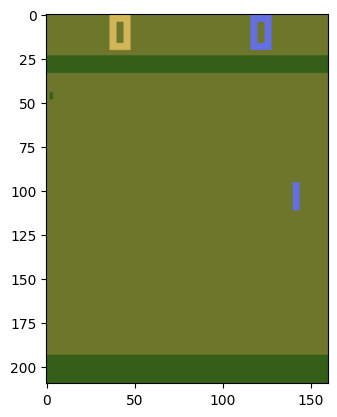

In [5]:
raw_env = gym.make('Pong-v4', render_mode='rgb_array')
raw_env.reset()
plt.imshow(raw_env.render())
raw_env.close()


In [ ]:
state_dims = raw_env.observation_space.shape
num_actions = raw_env.action_space.n
print(f"state space: {state_dims} , action space: {num_actions}")

state space: (210, 160, 3) , action space: 6


### Environment state pre-processing

As noted in the paper by Mnih et al. (2015), using the original, RGB-rendered arrays might be too computationally expensive. For that matter, the luminance is extracted from each frame by applying the mapping $\phi: \mathbb{R}^3 \to \mathbb{R}^2$

\begin{align}
\phi(R,G,B) = 0.2126 \times R + 0.7152 \times G + 0.0722 \times B
\end{align}

Then, the resulting matrix is rescaled to be $84 \times 84$ pixels in size.

To speed up training, $k=4$ frames are stacked together before being fed to the model. The same action taken by the model is repeated $k$ times, once per frame. In addition, pixel-wise maximum value between consecutive frames is used to avoid flickering. Therefore, the final size of the matrix fed to the model is $84 \times 84 \times 4$.

In [8]:
def get_luminance(arr: np.ndarray) -> np.ndarray:
    return 0.2126*arr[..., 0] + 0.7152*arr[..., 1] + 0.0722*arr[..., 2]

In [ ]:
class PreprocessEnv(gym.Wrapper):
    def __init__(self, env, n_frames=4):
        super().__init__(env)
        self.n_frames = n_frames
        # Resizing PyTorch function
        self.transf = Resize((84, 84))

    def get_frame_stack(self, initial: np.ndarray, action: torch.Tensor):
        frames = []
        for i in range(self.n_frames):
            # Take an action and return the next_state
            next_state, reward, done, truncated, info = self.env.step(action)
    
            # Keep the maximum value of the pixel w.r.t. the previous frame to remove flickering
            next_state = np.maximum(initial, next_state)
            
            # Extract luminance and rescale
            next_lum = get_luminance(next_state)/255.
            next_lum = torch.from_numpy(next_lum).float()
            next_lum = self.transf(next_lum.unsqueeze(0).unsqueeze(0))

            # Append matrix to stack them later on
            frames.append(next_lum.squeeze())

            # Set the initial to be the current state
            initial = next_state

        stacked_states = torch.stack(frames, axis=0).unsqueeze(0)
        reward = np.clip(reward, -1, 1)
        return stacked_states, reward, done, truncated, info

    def reset(self):
        # Unpack observation and info from the new Gym API
        initial, _ = self.env.reset()
        action = torch.tensor(0)

        # Get the first 4 stacked frames by passing NOON action
        stacked_states, _, _, _, _ = self.get_frame_stack(initial, action)
        return stacked_states.to("cuda:0")

    def step(self, action):
        action = action.item()  # Convert torch tensor to scalar
        initial = self.env.render()
        
        # Get the next 4 stacked frames by passing the chosen action
        stacked_states, reward, done, truncated, info = self.get_frame_stack(initial, action)
        reward = torch.tensor(reward).view(1, -1).float()
        done = torch.tensor(done).view(1, -1) 
        return stacked_states.to("cuda:0"), reward.to("cuda:0"), done.to("cuda:0"), info

In [10]:
env = PreprocessEnv(raw_env)

state = env.reset()
action = torch.tensor(0)
next_state, reward, done, _ = env.step(action)
print(f"Sample state: {state}")
print(f"Next state: {next_state}, Reward: {reward}, Done: {done}")

Sample state: tensor([[[[0.3158, 0.3158, 0.3158,  ..., 0.4632, 0.4632, 0.4632],
          [0.4632, 0.4632, 0.4632,  ..., 0.4632, 0.4632, 0.4632],
          [0.4632, 0.4632, 0.4632,  ..., 0.4632, 0.4632, 0.4632],
          ...,
          [0.9255, 0.9255, 0.9255,  ..., 0.9255, 0.9255, 0.9255],
          [0.9255, 0.9255, 0.9255,  ..., 0.9255, 0.9255, 0.9255],
          [0.9255, 0.9255, 0.9255,  ..., 0.9255, 0.9255, 0.9255]],

         [[0.3158, 0.3158, 0.3158,  ..., 0.4632, 0.4632, 0.4632],
          [0.4632, 0.4632, 0.4632,  ..., 0.4632, 0.4632, 0.4632],
          [0.4632, 0.4632, 0.4632,  ..., 0.4632, 0.4632, 0.4632],
          ...,
          [0.9255, 0.9255, 0.9255,  ..., 0.9255, 0.9255, 0.9255],
          [0.9255, 0.9255, 0.9255,  ..., 0.9255, 0.9255, 0.9255],
          [0.9255, 0.9255, 0.9255,  ..., 0.9255, 0.9255, 0.9255]],

         [[0.3158, 0.3158, 0.3158,  ..., 0.4632, 0.4632, 0.4632],
          [0.4632, 0.4632, 0.4632,  ..., 0.4632, 0.4632, 0.4632],
          [0.4632, 0.4632, 0

## DQN agent

A deep Q-network (DQN) is a deep convolutional network (CNN) that approximates the optimal action-value function

\begin{align}
Q^*(s,a)= \max_{\pi} \mathbb{E}[r_t+\gamma r_{t+1}+\gamma^2 r_{t+2}+ \dots|s_t=s,a_t=a,\pi]
\end{align}

which is the maximum amount of rewards achievable by the agent after making an observation $s$ and taking an action $a$.

Because the agent only has access to rendered images, it becomes advantageous to use a CNN instead of a fully-connected network to analyze the frames. Therefore, we adopt this architecture in the present work.

### DQN model architecture

The CNN model used takes the stacked frames of size $84 \times 84 \times 4$ as input, and outputs the modeled Q-values of each of the 6 possible actions. To do so, the following layers are stacked:

1. ***Convolutional layer 1*** - with 32 filters of size $8 \times 8$ applied with stride 4.
2. ***ReLU layer 1***.
3. ***Convolutional layer 2*** - with 64 filters of size $4 \times 4$ applied with stride 2.
4. ***ReLU layer 2***.
5. ***Convolutional layer 3*** - with 64 filters of size $3 \times 3$ applied with stride 1.
6. ***ReLU layer 3***.
7. ***Flatten layer***, where the matrix is stretched into a vector.
8. ***Fully-connected layer 1*** - with 512 neurons.
9. ***ReLU layer 4***.
10. ***Output layer*** - with as many neurons as possible actions, that is, 6.


In [14]:
class DQN(nn.Module):
    def __init__(self, n_actions: int):
        super().__init__()
        self.n_actions = n_actions

        self.activation = nn.ReLU()
        self.conv_1 = nn.Conv2d(4, 32, (8, 8), (4, 4))
        self.conv_2 = nn.Conv2d(32, 64, (4, 4), (2, 2))
        self.conv_3 = nn.Conv2d(64, 64, (3, 3), (1, 1))
        self.flatten = nn.Flatten()
        self.fcl_1 = nn.Linear(3136, 512)
        self.fcl_out = nn.Linear(512, n_actions)
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.activation(x)
        x = self.conv_2(x)
        x = self.activation(x)
        x = self.conv_3(x)
        x = self.activation(x)
        x = self.flatten(x)
        x = self.fcl_1(x)
        x = self.activation(x)
        return self.fcl_out(x)

### Q-Network agent instantiation

The DQN agent $Q(s,a|\theta)$ is instantiated as follows:

In [16]:
q_network = DQN(num_actions).to("cuda:0")

### Target Q-Network deep copy

During training, the weights of the DQN agent are copied to generate the target Q-network $Q(s,a|\theta^-)$, from which we model the Q-value achieveable **after** taking action $a$. The weights of the target network remain frozen during training, and are only updated every $10$ episodes as $Q(s,a|\theta^-)=Q(s,a|\theta)$.

In [18]:
target_q_network = deepcopy(q_network).eval()

### Define exploratory policy

At each iteration, we apply an $\epsilon$-greedy exploratory policy where the action taken by the agent is decided according to the maximum modeled Q-value for the remainder of the game as $a_{t}=  \text{arg} \max_{a} Q(s,a|\theta)$. However, with some probability $\epsilon$ a random action will be taken instead.

In [78]:
def policy(state, epsilon=0.):
    if torch.rand(1) < epsilon:
        return torch.randint(num_actions, (1, 1)).to("cuda:0")
    else:
        av = q_network(state.to("cuda:0")).detach()
        return torch.argmax(av, dim=-1, keepdim=True)

## Training algorithm

To train the algorithm we first need to compute the sum of the reward $r$ after taking an action $a$ at time $t$ and the expected Q-value for the remainder of the game starting at time $t+1$, which is modeled by the target Q-network $Q(s,a|\theta^-)$. Then, we subtract the expected Q-value for the remainder of the game starting from time $t$, which is modeled by our Q-network $Q(s,a|\theta)$. The resulting expression is the Mean Squared Error (MSE) between the estimated ground truth and the predicted Q-values, which is used as the loss function as follows

\begin{align}
L_t(\theta_t)=\mathbb{E}_{(s,a,r,s')\sim U(D)}\left[\left(r + \gamma \max_{a'} Q(s',a'|\theta_t^-) - Q(s,a|\theta_t)\right)^2\right]
\end{align}

Where $s'$ is the resulting state after applying action $a$, and $a'$ is the preferred action by target model $Q(s',a'|\theta^-)$ when fed $s'$.

### Replay Memory

As in the Cartpole case, we store transitions $(s_t,a_t,r_t,s_{t+1})$ into a memory pool from which we sample to rehearse and learn from past experiences. However, contrary to the Cartpole case, each state $s_t$ is a $84\times84\times4$ matrix, which makes it **unfeasible to store millions of transitions in a consumer-grade computer**. Therefore, we use a lower memory capacity value of $50000$ during training. 

In [40]:
class ReplayMemory:

    def __init__(self, capacity=50000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        assert self.can_sample(batch_size)

        batch = random.sample(self.memory, batch_size)
        batch = zip(*batch)
        return [torch.cat(items).to("cuda:0") for items in batch]

    def can_sample(self, batch_size):
        return len(self.memory) >= batch_size * 10

    def __len__(self):
        return len(self.memory)

### Training loop

Like in the case of Cartpole, we make the agent play the game and store the transitions into the memory pool. Then, we sample a batch of $32$ past experiences randomly $(s_t,a_t,r_t,s_{t+1})$ and run an optimization cycle on the Q-network $Q(s,a|\theta)$. We also keep count of the amount of frames seen by the agent $N_{seen}$ and interrupt the training process when $N_{train}=20.000.000$ frames are reached, such that $N_{seen} \ge N_{train}$. During the first $1.000.000$ frames, the random action probability $\epsilon$ of the exploratory policy is linearly annealed from $1$ to $0.1$ $(\epsilon_t \in [0.1, 1])$, allowing the agent to explore the action space before having to make its own decisions.

In [ ]:
def deep_q_learning(q_network, policy, n_frames, alpha=0.0001, batch_size=32, gamma=0.99, eps_initial=1., eps_final=0.1, n_eps_decay=1_000_000):
  optim = AdamW(q_network.parameters(), lr=alpha)
  memory = ReplayMemory()
  stats = {'MSE Loss' : [], 'Returns' : []}

  step_size = (eps_initial - eps_final)/n_eps_decay
  n_steps = 0

  episode = 1
  while True:
    state = env.reset()
    done = False
    # Compute the return of each episode:
    ep_return = 0

    while not done:
      # Modify epsilon as the number of frames used goes up
      epsilon = max(eps_initial-step_size*n_steps, eps_final)
      action = policy(state, epsilon)
      next_state, reward, done, _ = env.step(action)
      n_steps += 1

      # Store the current transition into the memory pool
      memory.insert([state.clone(), action.clone(), reward.clone(), done.clone(), next_state.clone()])
      if memory.can_sample(batch_size):
        # Sample past transitions from the memory pool
        state_b, action_b, reward_b, done_b, next_state_b = memory.sample(batch_size)
          
        # Compute the Q values for the current states s
        qsa_b = q_network(state_b).gather(1, action_b)

        # Compute the Q values for the next states s' using the target network
        next_qsa_b = target_q_network(next_state_b)

        # Keep the highest q value
        next_qsa_b = torch.max(next_qsa_b, dim=-1, keepdim=True)[0]

        # Evaluate the loss function
        target_b = reward_b + ~done_b * gamma * next_qsa_b
        loss = F.mse_loss(qsa_b, target_b)

        # Wipe gradiants from nn
        q_network.zero_grad()
        
        # Update the DQN agent by backpropagating errors
        loss.backward()
        optim.step()

        stats['MSE Loss'].append(loss.item())

      state = next_state
      ep_return += reward.item()

    stats['Returns'].append(ep_return)

    # Every 10 episodes update the target CNN by copying the current weights of our DQN agent
    if episode % 10 == 0 :
      print(f"{episode} - Frame {n_steps}/{n_frames} - MSE Loss: {loss.item()}, Returns: {ep_return}, Epsilon: {epsilon}")
      target_q_network.load_state_dict(q_network.state_dict())
    
    episode += 1
    if n_steps >= n_frames:
      return stats

In [46]:
stats = deep_q_learning(q_network, policy, 20_000_000)

10 - Frame 3058/20000000 - MSE Loss: 0.0022045602090656757, Returns: -7.0, Epsilon: 0.9972487
20 - Frame 5923/20000000 - MSE Loss: 0.0016460972838103771, Returns: -5.0, Epsilon: 0.9946702
30 - Frame 8875/20000000 - MSE Loss: 0.0025203940458595753, Returns: -5.0, Epsilon: 0.9920134
40 - Frame 11821/20000000 - MSE Loss: 0.004212539177387953, Returns: -4.0, Epsilon: 0.989362
50 - Frame 14971/20000000 - MSE Loss: 0.007663912605494261, Returns: -7.0, Epsilon: 0.986527
60 - Frame 17861/20000000 - MSE Loss: 0.02369234710931778, Returns: -5.0, Epsilon: 0.983926
70 - Frame 20701/20000000 - MSE Loss: 0.008506173267960548, Returns: -6.0, Epsilon: 0.98137
80 - Frame 23720/20000000 - MSE Loss: 0.02265486679971218, Returns: -5.0, Epsilon: 0.9786529
90 - Frame 26622/20000000 - MSE Loss: 0.00212089903652668, Returns: -11.0, Epsilon: 0.9760411
100 - Frame 29716/20000000 - MSE Loss: 0.003521821927279234, Returns: -9.0, Epsilon: 0.9732565
110 - Frame 32699/20000000 - MSE Loss: 0.009570610709488392, Retur

## Training results

The Mean Squared Error (MSE) loss was stored at each update cycle, and the returns were summed and stored every episode. This allowed us to compute the learning curves for the DQN agent. These curves strongly suggest the agent would have kept learning for much longer. In fact, the original paper recommends to expose the agent to some $50.000.000$ frames, more than twice as long as we trained our DQN agent. Nonetheless, it is clear than our agent exhibits signs of intelligent behaviour as accumulater reward at each episode approaches $0$.

Interestingly, the initial phase of the learning process is characterized by erratic behaviour and an increase in the valued of the loss function. As described earlier, during that time agent's actions are mostly random (because of the exploration policy) and are meant to help the agent understand better the action space. After $\epsilon$ reaches its final value of $0.1$, both MSE and accumulated reward start to slowly but steadily improve, meaning the agent is learning to take its own actions.

### Loss curve and accumulated reward

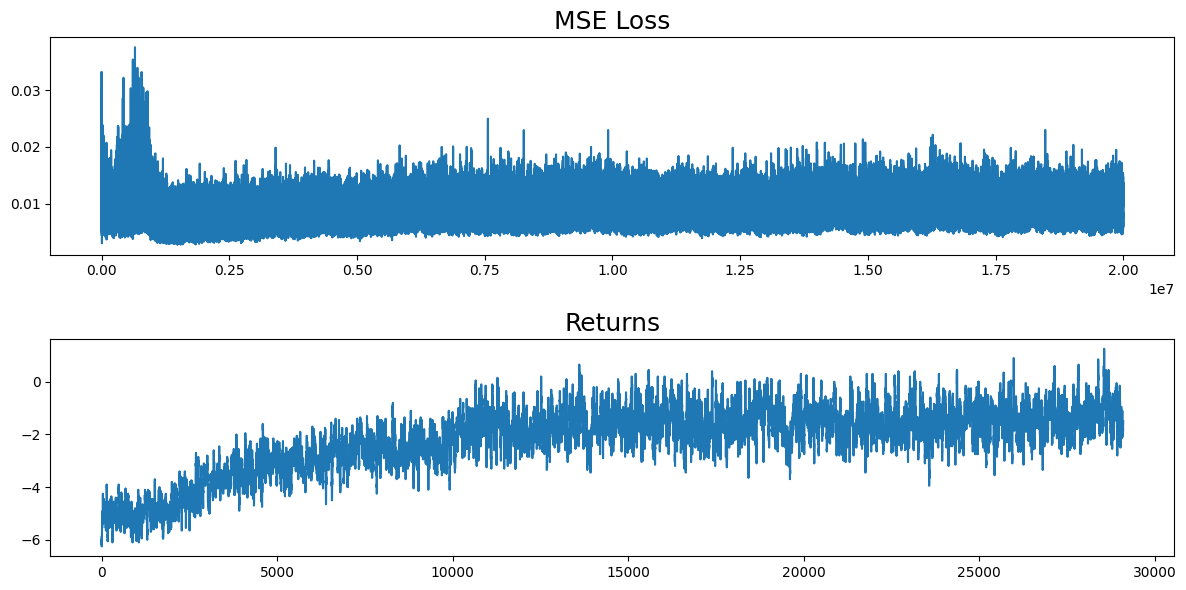

In [48]:
plot_stats(stats)

### Smoothed version of the Loss curve

In [52]:
window_size = 500
y_smooth = np.convolve(stats['MSE Loss'], np.ones(window_size)/window_size, mode='valid')

C:\Users\nimah\.pyenv\pyenv-win\versions\3.11.4\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


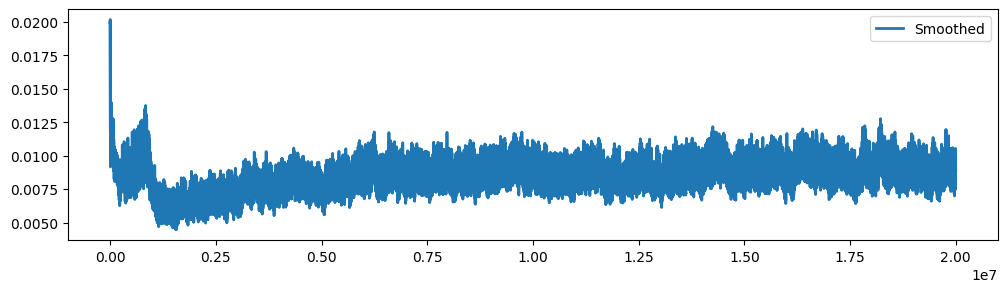

In [54]:
plt.rcParams["figure.figsize"] = (12,3)
plt.plot(np.arange(y_smooth.size), y_smooth, label='Smoothed', linewidth=2)
plt.legend()
plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

## Agent performance

The behaviour of the DQN agent was visually evaluated by making it play Pong for 200 frames. As it can be seen in the short video below, the agent performs well and shows signs of intelligence. Some specially interesting behaviours are:

- **Staying put and waiting for the ball** when the direction of the ball matches the current position of the agent.

- **Scouting throughout the field** when it is unclear in which direction the ball will go.

- **Correcting the position** when the ball approaches the agent's side of the screen, but it is still far from the ball.



In [ ]:
def play_game(env, n_steps, epsilon=0.1) -> torch.Tensor:
    frames = []
    state = env.reset()
    
    frames.append(state.squeeze())
    for i in range(n_steps):
      action = policy(state, epsilon)
      state, reward, done, _ = env.step(action)
      frames.append(state.squeeze())
    return torch.cat(frames, dim=0)


def display_gif(frames, interval=50):
    fig, ax = plt.subplots()
    img = ax.imshow(frames[0])

    def update(frame):
        img.set_data(frame)
        return [img]

    anim = animation.FuncAnimation(fig, update, frames=frames, interval=interval, blit=True)
    plt.close(fig)  # Close the figure to prevent duplicate output

    # Save as GIF
    anim.save("agent_play.gif", writer="pillow", fps=1000 // interval)

    # Display the GIF
    return HTML(f'<img src="pong_agent_play.gif">')

In [ ]:
# Play for a while and display the resulting GIF
frames = play_game(env, 200, epsilon=0.1).cpu().numpy()
display_gif(frames)

## BONUS: Saving model weights and training stats

In order to save the progress attained during the training phase we stored the weights of the DQN agent anf the training stats at the last episode.

In [86]:
torch.save(q_network.state_dict(), "billy_checkpoint.pth")
print("q_network saved successfully.")

q_network saved successfully.


In [90]:
import pickle

# Save the `stats` variable to a file
with open("stats.pkl", "wb") as f:
    pickle.dump(stats, f)

print("Stats saved successfully!")


Stats saved successfully!
